# **Configuração Inicial**

In [1]:
!pip install openpyxl

In [2]:
import pandas as pd

In [6]:
df_original = pd.read_excel("Horas_parametros.xlsx")

In [7]:
df_original['HET'] = pd.to_numeric(df_original['HET'], errors='coerce')

separar conjunto de treino (HET existe)

In [8]:
df_train_full = df_original[df_original['HET'].notna()].copy()

separar conjnto de previsão (HET ausente)

In [9]:
df_predict = df_original[df_original['HET'].isna()].copy()

In [10]:
print(f"Número de amostras para TREINAMENTO (com HET): {len(df_train_full)}")
print(f"Número de amostras para PREVISÃO (sem HET): {len(df_predict)}")

Número de amostras para TREINAMENTO (com HET): 9999
Número de amostras para PREVISÃO (sem HET): 10743


pre-processamento - tratar valores ausentes nas caracteristicas




In [11]:
df_train_full.fillna(0, inplace=True)
df_predict.fillna(0, inplace=True)

definir dados de treinamento (x e y a partir de df_train_full)

In [12]:
X = df_train_full.drop(columns=['ID', 'HET'])
y = df_train_full['HET']

Dividir o conjunto de treinamento para validação

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Definir dados finais para previsão

In [15]:
X_final_prediction = df_predict.drop(columns=['ID', 'HET'])

In [16]:
print("\n--- Separação e Preparação Concluídas ---")
print(f"Tamanho de X_train (para treinar modelos): {X_train.shape}")
print(f"Tamanho de X_test (para validar modelos): {X_test.shape}")
print(f"Tamanho de X_final_prediction (para a previsão final): {X_final_prediction.shape}")


--- Separação e Preparação Concluídas ---
Tamanho de X_train (para treinar modelos): (7999, 295)
Tamanho de X_test (para validar modelos): (2000, 295)
Tamanho de X_final_prediction (para a previsão final): (10743, 295)


In [17]:
X_final_prediction = X_final_prediction[X_train.columns]

# **EDA com correlação ponto-bisserial**

In [18]:
from scipy.stats import pointbiserialr
import numpy as np

In [19]:
predictor_cols = [col for col in df_train_full.columns if col not in ['ID', 'HET']]

In [20]:
correlations = {}

In [21]:
print("Calculando correlações... ")

for col in predictor_cols:
    unique_values = df_train_full[col].unique()
    if np.isin(unique_values, [0, 1]).all():
        try:
            corr, p_value = pointbiserialr(df_train_full[col], df_train_full['HET'])
            correlations[col] = {'correlation': corr, 'p_value': p_value}
        except Exception as e:
            print(f"Não foi possível calcular a correlação para a coluna '{col}': {e}")

Calculando correlações... 


/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:5534: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


In [22]:
corr_df = pd.DataFrame.from_dict(correlations, orient='index')

In [23]:
corr_df['abs_correlation'] = corr_df['correlation'].abs()

In [24]:
corr_df_sorted = corr_df.sort_values(by='abs_correlation', ascending=False)

In [25]:
print("\n--- Top 20 Características Mais Correlacionadas com HET ---")
print(corr_df_sorted[['correlation', 'p_value']].head(20))


--- Top 20 Características Mais Correlacionadas com HET ---
             correlation        p_value
01.02           0.662605   0.000000e+00
03.01          -0.546044   0.000000e+00
01.07.01       -0.482773   0.000000e+00
02.08           0.460962   0.000000e+00
05.01          -0.454533   0.000000e+00
12.04           0.432227   0.000000e+00
12.02           0.431221   0.000000e+00
05.04           0.409293   0.000000e+00
07.14           0.398710   0.000000e+00
05.02           0.355914  2.085657e-296
02.14           0.346707  2.245391e-280
10.09           0.338571  1.187015e-266
02.13          -0.338137  6.237890e-266
08.16           0.334547  5.138237e-260
02.10           0.333047  1.442643e-257
04.10           0.327627  7.785466e-249
06.03           0.301304  6.611612e-209
07.15           0.299146  8.210047e-206
06.04           0.295212  3.073716e-200
02.15           0.278822  5.907509e-178


# **Modelagem com Regressão Lasso e Otimização**

In [26]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold
import warnings

In [27]:
warnings.filterwarnings('ignore', category=UserWarning)

In [28]:
lasso = Lasso(max_iter=10000, random_state=42)
param_grid_lasso = {'alpha': [0.01, 0.1, 0.5, 1, 5, 10]}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
print("Iniciando a otimização do modelo Lasso com validação cruzada...")
print(f"Testando os seguintes valores para alpha: {param_grid_lasso['alpha']}")

grid_search_lasso = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid_lasso,
    cv=kfold,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

Iniciando a otimização do modelo Lasso com validação cruzada...
Testando os seguintes valores para alpha: [0.01, 0.1, 0.5, 1, 5, 10]


In [30]:
grid_search_lasso.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Lasso(max_iter=10000, random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1, 5, 10]},
             scoring='neg_root_mean_squared_error')

In [31]:
best_lasso = grid_search_lasso.best_estimator_

In [32]:
print("\n--- Otimização do Lasso Concluída ---")
print(f"O melhor valor de alpha encontrado foi: {grid_search_lasso.best_params_['alpha']}")
print(f"RMSE médio na validação cruzada com o melhor alpha: {-grid_search_lasso.best_score_:.4f}")


--- Otimização do Lasso Concluída ---
O melhor valor de alpha encontrado foi: 0.01
RMSE médio na validação cruzada com o melhor alpha: 8.8524


**Avaliação do modelo Lasso**

In [33]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

In [34]:
print("\nAvaliando o modelo Lasso no conjunto de teste/validação...")
predictions_lasso = best_lasso.predict(X_test)
r2_lasso = r2_score(y_test, predictions_lasso)
mae_lasso = mean_absolute_error(y_test, predictions_lasso)
rmse_lasso = root_mean_squared_error(y_test, predictions_lasso)


Avaliando o modelo Lasso no conjunto de teste/validação...


In [35]:
print("\n--- Resultados do Modelo Lasso ---")
print(f"R-quadrado (R²): {r2_lasso:.4f}")
print(f"Erro Médio Absoluto (MAE): {mae_lasso:.4f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse_lasso:.4f}")


--- Resultados do Modelo Lasso ---
R-quadrado (R²): 0.7420
Erro Médio Absoluto (MAE): 5.3086
Raiz do Erro Quadrático Médio (RMSE): 7.9548


In [36]:
n_selected_features = np.sum(best_lasso.coef_ != 0)
print(f"O modelo selecionou {n_selected_features} de {X_train.shape[1]} características.")

O modelo selecionou 108 de 295 características.


# **Modelagem com XGBoost e otimização**

In [37]:
!pip install xgboost

In [38]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold
import warnings

In [39]:
warnings.filterwarnings('ignore', category=UserWarning)

definindo o modelo XGBoost

In [40]:
xgboost = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

definindo grade de paramentros

In [41]:
param_grid_xgb = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

configurar a validação cruzada (K-Fold)

In [42]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

configurar e executar o GridSearchCV

In [43]:
print("Iniciando a otimização do modelo XGBoost com validação cruzada...")
print(f"Total de combinações a testar: {len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['max_depth']) * len(param_grid_xgb['subsample'])} x 5 folds = 80 modelos.")

grid_search_xgb = GridSearchCV(
    estimator=xgboost,
    param_grid=param_grid_xgb,
    cv=kfold,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

Iniciando a otimização do modelo XGBoost com validação cruzada...
Total de combinações a testar: 16 x 5 folds = 80 modelos.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    impo...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 300], 'subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error')

capturar o melhor modelo de XGBoost

In [44]:
best_xgb = grid_search_xgb.best_estimator_

print("\n--- Otimização do XGBoost Concluída ---")
print(f"Os melhores parâmetros encontrados foram: {grid_search_xgb.best_params_}")
print(f"RMSE médio na validação cruzada (RMSE de Treino): {-grid_search_xgb.best_score_:.4f}")


--- Otimização do XGBoost Concluída ---
Os melhores parâmetros encontrados foram: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
RMSE médio na validação cruzada (RMSE de Treino): 9.0621


# **Avaliação final do modelo XGBoost**

In [45]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

usar o melhor modelo XGBoost encontrado para fazer previsões

In [46]:
predictions_xgb = best_xgb.predict(X_test)

calcular as metricas de desempenho

In [47]:
r2_xgb = r2_score(y_test, predictions_xgb)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
rmse_xgb = root_mean_squared_error(y_test, predictions_xgb)

print("\n--- Resultados Finais do Modelo XGBoost no Conjunto de Teste ---")
print(f"R-quadrado (R²): {r2_xgb:.4f}")
print(f"Erro Médio Absoluto (MAE): {mae_xgb:.4f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse_xgb:.4f}")


--- Resultados Finais do Modelo XGBoost no Conjunto de Teste ---
R-quadrado (R²): 0.7361
Erro Médio Absoluto (MAE): 5.3517
Raiz do Erro Quadrático Médio (RMSE): 8.0442


# **Analise comparativa e decisão de modelo**

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Criar dataframe para a comparação usando as variaves que foram definidas nas células anteriores

In [49]:
results_data = {
    'Métrica': ['R-quadrado (R²)', 'Erro Médio Absoluto (MAE)', 'RMSE'],
    'Modelo Lasso': [f"{r2_lasso:.4f}", f"{mae_lasso:.4f} horas", f"{rmse_lasso:.4f} horas"],
    'Modelo XGBoost': [f"{r2_xgb:.4f}", f"{mae_xgb:.4f} horas", f"{rmse_xgb:.4f} horas"]
}
results_df = pd.DataFrame(results_data)

print("--- Tabela de Desempenho Comparativo ---")
print(results_df.to_string(index=False))

--- Tabela de Desempenho Comparativo ---
                  Métrica Modelo Lasso Modelo XGBoost
          R-quadrado (R²)       0.7420         0.7361
Erro Médio Absoluto (MAE) 5.3086 horas   5.3517 horas
                     RMSE 7.9548 horas   8.0442 horas


calcular erros de cada modelo

In [50]:
erros_lasso = y_test - predictions_lasso
erros_xgb = y_test - predictions_xgb

criar datafram com os erros

In [51]:
df_erros = pd.DataFrame({
    "Modelo Lasso": erros_lasso,
    "Modelo XGBoost": erros_xgb
})

configurar e criar o grafico

In [52]:
plt.figure(figsize=(12,7))
sns.set_style("white")

<Figure size 1200x700 with 0 Axes>

# **Gráfico de comparação**

**Pico Mais Alto do Lasso**: A curva verde (Lasso) atinge um ponto de densidade ligeiramente mais alto (mais próximo de 0.07) do que a curva vermelha (XGBoost). Isso significa que o modelo Lasso teve uma frequência maior de previsões com erro muito próximo de zero.

**Concentração em Torno de Zero**: Ambas as curvas estão bem centradas em torno da linha preta, indicando que nenhum dos modelos tem um viés (bias) significativo para superestimar ou subestimar as horas.

**Dispersão Similar**: A largura das curvas é muito parecida, o que significa que a dispersão geral dos erros é semelhante. No entanto, o pico mais alto do Lasso indica que ele é marginalmente mais consistente.

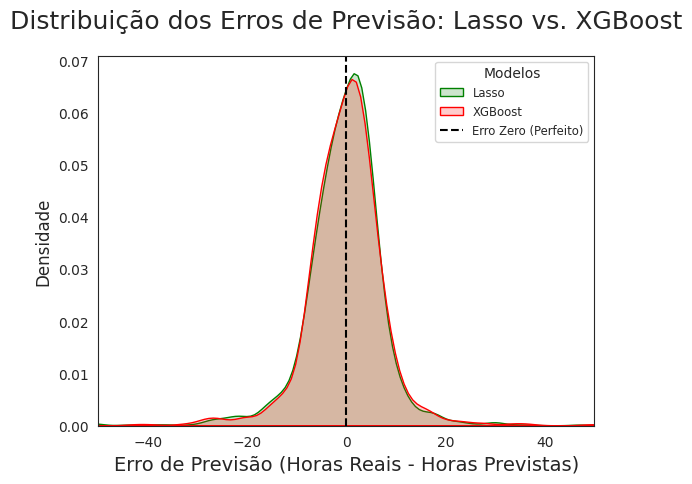

In [53]:
sns.kdeplot(data=df_erros, x="Modelo Lasso", label="Lasso", color="green", fill=True, alpha=0.2)
sns.kdeplot(data=df_erros, x="Modelo XGBoost", label="XGBoost", color="red", fill=True, alpha=0.2)

plt.axvline(x=0, color="black", linestyle="--", linewidth=1.5, label="Erro Zero (Perfeito)")

plt.title("Distribuição dos Erros de Previsão: Lasso vs. XGBoost", fontsize=18, pad=20)
plt.xlabel("Erro de Previsão (Horas Reais - Horas Previstas)", fontsize=14)
plt.ylabel("Densidade", fontsize='large')
plt.legend(title="Modelos", fontsize='small')
plt.xlim(-50, 50)
plt.show()

# **Interpretação e Previsão final**

**Interpretação do modelo**

Criar dataframe com as caracteristicas e seus respectivios coeficientes

In [54]:
coefs = pd.DataFrame({
    'Característica': X_train.columns,
    'Coeficiente_Lasso': best_lasso.coef_
})

filtrar caracteristicas que o Lasso não zerou

In [55]:
coefs_importantes = coefs[coefs['Coeficiente_Lasso'] != 0].copy()

criar uma coluna com o valor absoluto do coeficiente para ordenar por importancia

In [56]:
coefs_importantes['Importancia'] = coefs_importantes['Coeficiente_Lasso'].abs()

ordenar da mais importante par a menos importante

In [57]:
coefs_importantes_sorted = coefs_importantes.sort_values(by='Importancia', ascending=False)

mostrar as 15 caracteristicas de maior impacto

In [58]:
print("\nTop 15 Características com Maior Impacto no Tempo (HET):")
print(coefs_importantes_sorted[['Característica', 'Coeficiente_Lasso']].head(15).to_string(index=False))


Top 15 Características com Maior Impacto no Tempo (HET):
Característica  Coeficiente_Lasso
      02.05             17.875647
      08.18             17.407262
      04.14             16.415970
      04.15             15.840653
      03.09             13.919911
      02.10             13.517051
      02.07             12.241909
      03.10             12.168251
      03.08             11.221820
      03.06             10.706455
      07.17              9.574918
      02.12              8.703049
      08.17              8.575688
      06.05              8.362892
      03.05              8.003893


**Previsão Final**

variavel com as previsões faltantes. usar o melhor modelo do lasso.

In [59]:
final_predictions = best_lasso.predict(X_final_prediction)

adicionar as previsões ao dataframe original que não tinha HET

In [60]:
df_predict['HET'] = final_predictions

mostra as 5 primeiras linhas do dataframe com as previsões preenchidas

In [61]:
print("\nAmostra dos dados com a previsão de HET preenchida:")
print(df_predict[['ID', 'HET']].head())


Amostra dos dados com a previsão de HET preenchida:
          ID        HET
9999   10000  19.789423
10000  10001  10.312262
10001  10002  32.447055
10002  10003   8.212117
10003  10004  46.971017


# **Interpretação com SHAP Values**

In [62]:
import shap

cria "explicador" shap

In [63]:
explainer_xgb = shap.TreeExplainer(best_xgb)

calcula a contribuição de cada caracteristica para cada previsão individual

In [64]:
shap_values_xgb = explainer_xgb.shap_values(X_test)

grafico de importancia global (bar plot)

Este gráfico ranqueia as características pela sua magnitude de impacto média, ou seja, quais delas mais "movimentam" o ponteiro da previsão, independentemente da direção.

**Dominância Clara:** A característica 01.02 é, de longe, a mais importante para o modelo XGBoost. Seu impacto médio é quase o triplo da segunda colocada (03.01). Isso indica que saber se o processo tem ou não a característica 01.02 é a informação mais valiosa para o modelo.

**Top 3 Consistente**: As características 01.02, 03.01 e 07.14 se destacam como as mais influentes. É muito provável que essas sejam as mesmas que tiveram os maiores coeficientes no seu modelo Lasso. Isso é uma validação cruzada de modelos: quando dois algoritmos diferentes concordam sobre as variáveis mais importantes, nossa confiança nelas aumenta exponencialmente.

**Impacto Decrescente:** Após as primeiras características, a importância cai de forma mais gradual, mostrando que há um conjunto secundário de variáveis que contribuem de forma mais modesta, mas ainda relevante, para a previsão.

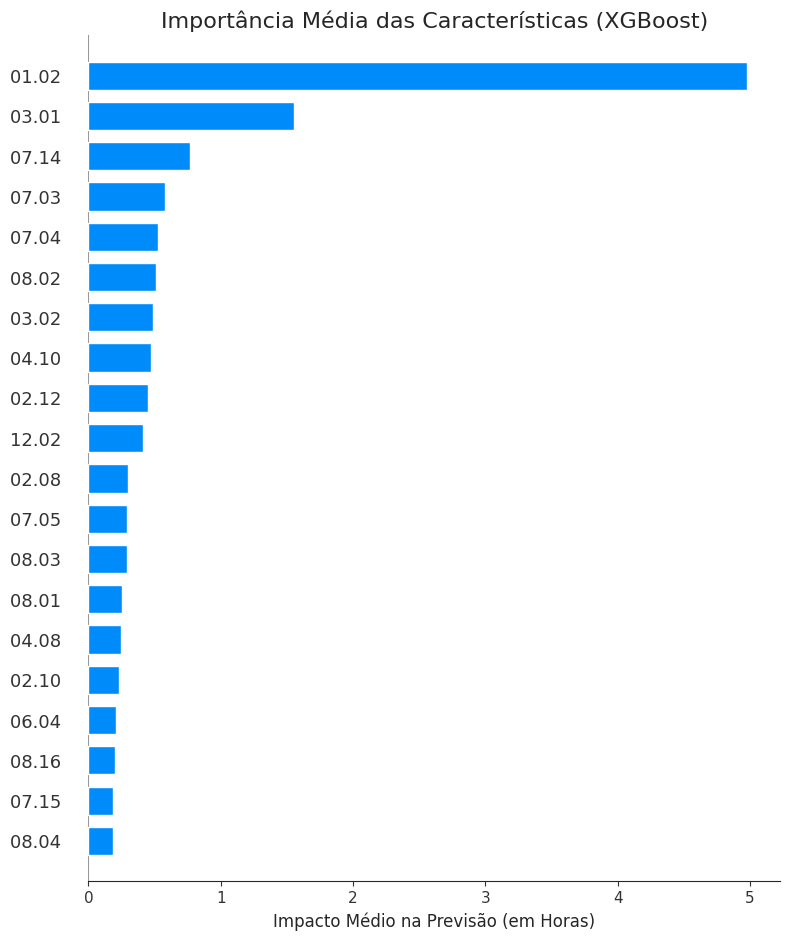

In [68]:
plt.title("Importância Média das Características (XGBoost)", fontsize=16)
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=False)
plt.xlabel("Impacto Médio na Previsão (em Horas)", fontsize=12)
plt.title("Importância Média das Características (XGBoost)", fontsize=16)
plt.show()

grafico de densidade de impacto (Bee swarm plot)

Ele nos diz não apenas quais características são importantes, mas como e por quê. (Lembre-se: vermelho = 1/Presença, azul = 0/Ausência).

**01.02 (Aumenta o Tempo):** A análise é cristalina. Quase todos os pontos vermelhos (presença da característica) estão à direita, com valores SHAP positivos. Isso significa que a presença de 01.02 consistentemente e fortemente aumenta a previsão de horas. O impacto pode chegar a adicionar mais de 20 horas à previsão em alguns casos.

**03.01 (Diminui o Tempo):** Aqui vemos o oposto. A grande maioria dos pontos vermelhos está à esquerda, com valores SHAP negativos. Portanto, a presença de 03.01 consistentemente diminui a previsão de horas, reduzindo a estimativa em até 5 horas.

**07.14 (Aumenta o Tempo):** Similar ao 01.02, mas com um impacto menor. Os pontos vermelhos estão majoritariamente à direita. A presença de 07.14 tende a aumentar a previsão de horas.

**07.03, 07.04, 08.02 (Diminuem o Tempo):** Todas essas características mostram um padrão claro onde os pontos vermelhos estão à esquerda da linha zero. A presença de qualquer uma delas contribui para uma redução na previsão de horas.

**04.10, 12.02, 06.04 (Aumentam o Tempo):** Essas características, e várias outras abaixo, mostram o padrão de pontos vermelhos à direita, indicando que sua presença aumenta a estimativa de HET.

**02.08 (Impacto Misto/Interativo):** Esta é interessante. Vemos pontos vermelhos tanto à esquerda quanto à direita. Isso sugere que o efeito de 02.08 pode depender de outras características. Ele não tem um impacto unidirecional claro, algo que um modelo linear como o Lasso teria dificuldade em capturar.

Este gráfico mostra como o valor de uma característica (cor) afeta a previsão (eixo x).


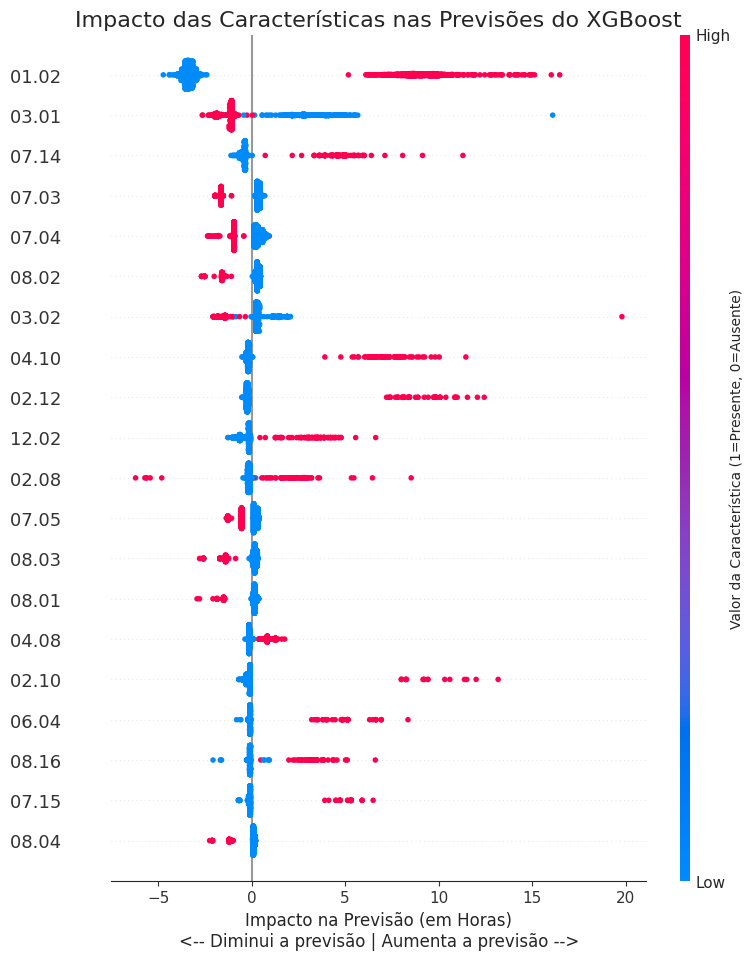

In [69]:
print("Este gráfico mostra como o valor de uma característica (cor) afeta a previsão (eixo x).")
plt.title("Impacto das Características nas Previsões do XGBoost", fontsize=16)
shap.summary_plot(shap_values_xgb, X_test, show=False)
plt.xlabel("Impacto na Previsão (em Horas)\n<-- Diminui a previsão | Aumenta a previsão -->", fontsize=12)
cb = plt.gcf().axes[-1] # Pega a última barra de cores criada
cb.set_ylabel("Valor da Característica (1=Presente, 0=Ausente)", fontsize=10)
plt.show()

configuração da validação cruzada

In [71]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metric = 'neg_root_mean_squared_error'

dicionarios para armazenar os resultados finais

In [78]:
model_results = {}
model_predictions = {}

# **Random Forest**

In [73]:
from sklearn.ensemble import RandomForestRegressor

In [75]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, None], # None = até a folha ser pura
    'min_samples_split': [2, 5]
}

In [76]:
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=kfold, scoring=scoring_metric, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
predictions_rf = best_rf.predict(X_test)

In [79]:
model_predictions['Random Forest'] = predictions_rf
model_results['Random Forest'] = {
    'R²': r2_score(y_test, predictions_rf),
    'MAE': mean_absolute_error(y_test, predictions_rf),
    'RMSE': root_mean_squared_error(y_test, predictions_rf),
    'Best Params': grid_search_rf.best_params_
}
print(f"Random Forest concluído. Melhores parâmetros: {grid_search_rf.best_params_}\n")

Random Forest concluído. Melhores parâmetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}



# **Regressão Huber**

In [81]:
from sklearn.linear_model import HuberRegressor

In [82]:
huber = HuberRegressor(max_iter=500)
param_grid_huber = {
    'epsilon': [1.35, 1.5], # Controla a robustez a outliers
    'alpha': [0.0001, 0.01]   # Força da regularização
}

In [83]:
grid_search_huber = GridSearchCV(huber, param_grid_huber, cv=kfold, scoring=scoring_metric, n_jobs=-1)
grid_search_huber.fit(X_train, y_train)
best_huber = grid_search_huber.best_estimator_
predictions_huber = best_huber.predict(X_test)

In [84]:
model_predictions['Huber'] = predictions_huber
model_results['Huber Regressor'] = {
    'R²': r2_score(y_test, predictions_huber),
    'MAE': mean_absolute_error(y_test, predictions_huber),
    'RMSE': root_mean_squared_error(y_test, predictions_huber),
    'Best Params': grid_search_huber.best_params_
}
print(f"Huber Regressor concluído. Melhores parâmetros: {grid_search_huber.best_params_}\n")

Huber Regressor concluído. Melhores parâmetros: {'alpha': 0.01, 'epsilon': 1.5}



explicador shap

In [97]:
explainer_huber = shap.LinearExplainer(best_huber, X_train)

calcular valores shap

In [98]:
shap_values_huber = explainer_huber.shap_values(X_test)

grafico de importancia global

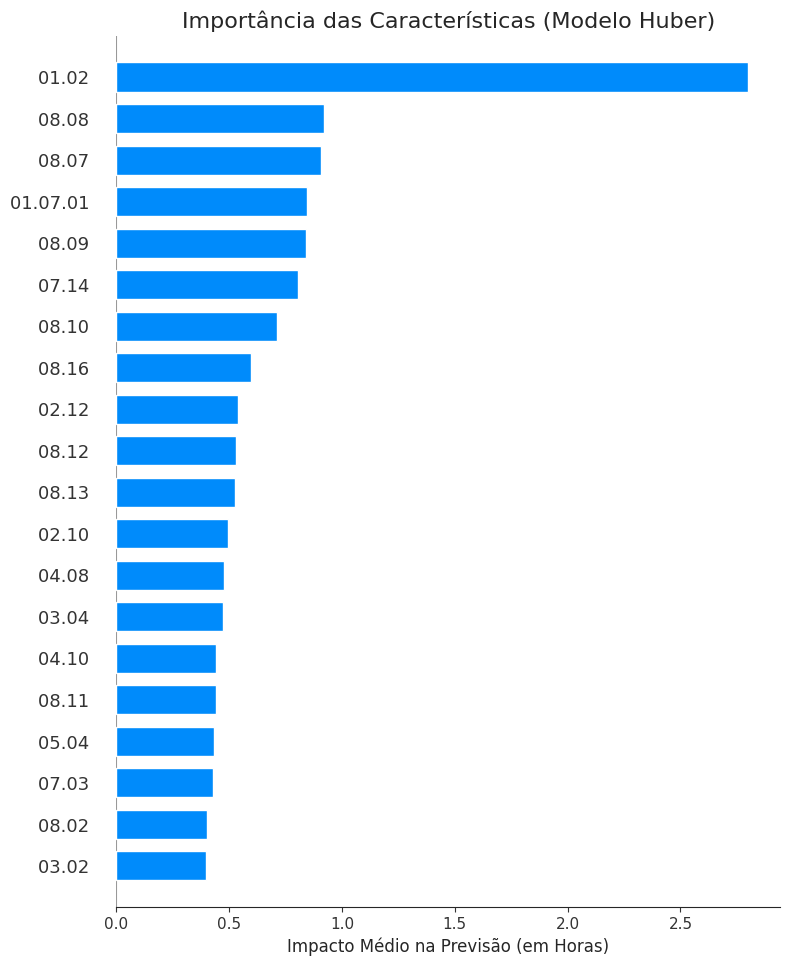

In [99]:
shap.summary_plot(shap_values_huber, X_test, plot_type="bar", show=False)
plt.xlabel("Impacto Médio na Previsão (em Horas)", fontsize=12)
plt.title("Importância das Características (Modelo Huber)", fontsize=16)
plt.show()

grafico de densidade

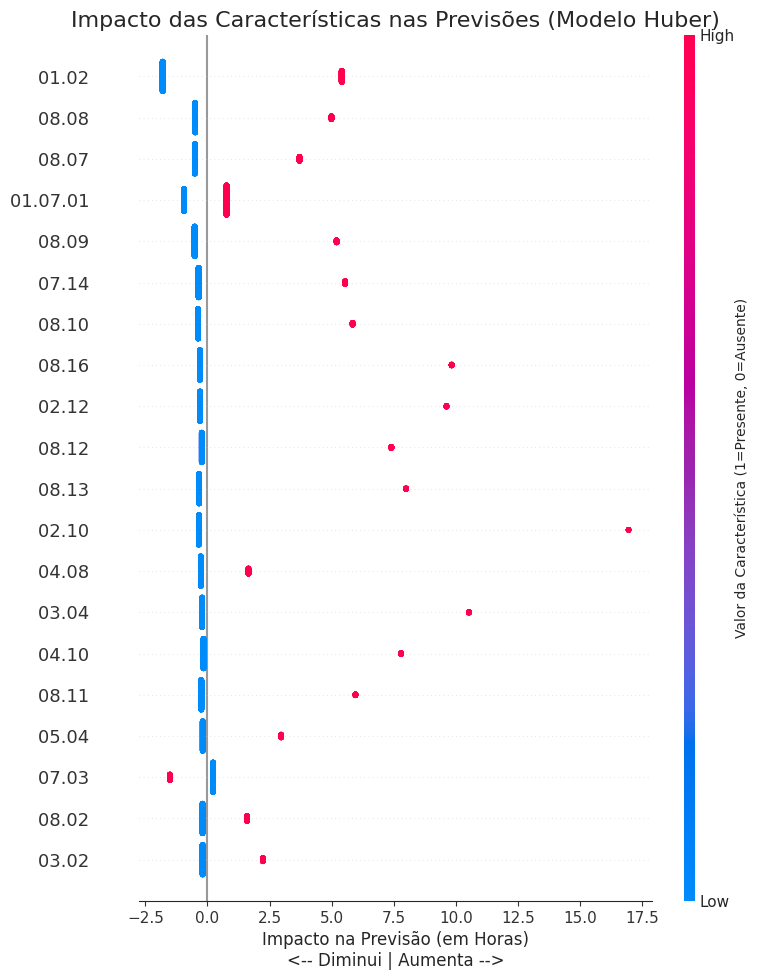

In [100]:
shap.summary_plot(shap_values_huber, X_test, show=False)
plt.xlabel("Impacto na Previsão (em Horas)\n<-- Diminui | Aumenta -->", fontsize=12)
cb = plt.gcf().axes[-1]
cb.set_ylabel("Valor da Característica (1=Presente, 0=Ausente)", fontsize=10)
plt.title("Impacto das Características nas Previsões (Modelo Huber)", fontsize=16)
plt.show()

# **Otimização de hiperparâmetros do Huber**

configurar modelo base

In [101]:
huber_advanced = HuberRegressor(max_iter=1000)

definir grade de parametros

In [102]:
param_grid_huber_advanced = {
    'epsilon': [1.1, 1.25, 1.35, 1.5, 1.75, 2.0],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

mesma configuração de validação cruzada

In [103]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metric = 'neg_root_mean_squared_error'

configurar e executar GridSearchCV

In [105]:
grid_search_huber_advanced = GridSearchCV(
    estimator=huber_advanced,
    param_grid=param_grid_huber_advanced,
    cv=kfold,
    scoring=scoring_metric,
    n_jobs=-1
)

treina modelo

In [106]:
grid_search_huber_advanced.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=HuberRegressor(max_iter=1000), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
                         'epsilon': [1.1, 1.25, 1.35, 1.5, 1.75, 2.0]},
             scoring='neg_root_mean_squared_error')

melhor modelo

In [107]:
best_huber_final = grid_search_huber_advanced.best_estimator_

In [108]:
print(f"Os melhores parâmetros encontrados foram: {grid_search_huber_advanced.best_params_}")
print(f"RMSE médio na validação cruzada (Treino): {-grid_search_huber_advanced.best_score_:.4f}")

Os melhores parâmetros encontrados foram: {'alpha': 0.1, 'epsilon': 2.0}
RMSE médio na validação cruzada (Treino): 8.6941


avalia modelo

In [109]:
predictions_huber_final = best_huber_final.predict(X_test)
r2_final = r2_score(y_test, predictions_huber_final)
mae_final = mean_absolute_error(y_test, predictions_huber_final)
rmse_final = root_mean_squared_error(y_test, predictions_huber_final)

novos resultados

In [110]:
print(f"Novo R-quadrado (R²): {r2_final:.4f}")
print(f"Novo Erro Médio Absoluto (MAE): {mae_final:.4f}")
print(f"Nova Raiz do Erro Quadrático Médio (RMSE): {rmse_final:.4f}")

Novo R-quadrado (R²): 0.7518
Novo Erro Médio Absoluto (MAE): 5.1788
Nova Raiz do Erro Quadrático Médio (RMSE): 7.8024


comparação com modelo antigo

In [111]:
print("\n--- Comparação com a Versão Anterior do Huber ---")
print(f"RMSE Anterior: {model_results['Huber Regressor']['RMSE']:.4f}")
print(f"RMSE Otimizado: {rmse_final:.4f}")
improvement = model_results['Huber Regressor']['RMSE'] - rmse_final
if improvement > 0:
    print(f"Melhora de {improvement:.4f} no RMSE!")
else:
    print("O desempenho permaneceu similar ou não melhorou.")


--- Comparação com a Versão Anterior do Huber ---
RMSE Anterior: 7.8861
RMSE Otimizado: 7.8024
Melhora de 0.0837 no RMSE!


# **Perceptron de Múltiplas Camadas**

In [90]:
from sklearn.neural_network import MLPRegressor

Padronização de dados

In [86]:
from sklearn.preprocessing import StandardScaler

In [88]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [91]:
mlp = MLPRegressor(max_iter=500, random_state=42, early_stopping=True)
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.05]
}

In [92]:
grid_search_mlp = GridSearchCV(mlp, param_grid_mlp, cv=kfold, scoring=scoring_metric, n_jobs=-1)
grid_search_mlp.fit(X_train_scaled, y_train)
best_mlp = grid_search_mlp.best_estimator_
predictions_nn = best_mlp.predict(X_test_scaled)

In [93]:
model_predictions['Rede Neural'] = predictions_nn
model_results['Rede Neural'] = {
    'R²': r2_score(y_test, predictions_nn),
    'MAE': mean_absolute_error(y_test, predictions_nn),
    'RMSE': root_mean_squared_error(y_test, predictions_nn),
    'Best Params': grid_search_mlp.best_params_
}
print(f"Rede Neural concluída. Melhores parâmetros: {grid_search_mlp.best_params_}\n")

Rede Neural concluída. Melhores parâmetros: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 25)}



# **Comparação Final entre modelos**

In [94]:
model_results['Lasso'] = {'R²': r2_lasso, 'MAE': mae_lasso, 'RMSE': rmse_lasso, 'Best Params': grid_search_lasso.best_params_}
model_results['XGBoost'] = {'R²': r2_xgb, 'MAE': mae_xgb, 'RMSE': rmse_xgb, 'Best Params': grid_search_xgb.best_params_}

**O Huber Regressor se destacou como o melhor modelo em todas as métricas. Ele teve o maior R², o menor MAE e o menor RMSE.**

A grande vantagem do Huber é sua capacidade de lidar com outliers (valores muito extremos) na variável alvo (HET). Enquanto a Regressão Linear (e o Lasso) penaliza erros grandes quadraticamente, o Huber os trata de forma linear após um certo limite (epsilon). Isso significa que alguns processos com "horas faltantes" muito altas (que podem ser anômalos) não "puxaram" o modelo Huber para longe do padrão geral, resultando em um erro médio menor para a maioria dos casos.

O fato de que os três melhores modelos (Huber, Lasso e Rede Neural) superaram os modelos baseados em árvores (XGBoost e Random Forest) é uma evidência fortíssima de que a relação subjacente nos seus dados é predominantemente linear. Os modelos de árvore, que buscam interações complexas, acabaram fazendo um leve overfitting nos dados de treino e não generalizaram tão bem quanto os modelos mais simples.

A Rede Neural chegou muito perto do desempenho do Lasso. Com mais camadas, neurônios ou um ajuste mais fino, ela poderia até superar. Seus melhores parâmetros (hidden_layer_sizes: (100,)) indicam que uma única camada oculta com 100 neurônios foi a arquitetura mais eficaz.

Embora não tenham vencido, o XGBoost e o Random Forest ainda apresentaram resultados decentes. O max_depth: None do Random Forest significa que as árvores cresceram até o fim, o que pode ter levado a um overfitting maior, explicando por que ele ficou em último lugar. O XGBoost, com max_depth: 3, foi mais contido e, por isso, teve um desempenho melhor.

In [96]:
pd.set_option('display.max_colwidth', None)

results_df_final = pd.DataFrame(model_results).T
results_df_final_formatted = results_df_final.copy()
results_df_final_formatted['R²'] = results_df_final_formatted['R²'].map('{:.4f}'.format)
results_df_final_formatted['MAE'] = results_df_final_formatted['MAE'].map('{:.4f}'.format)
results_df_final_formatted['RMSE'] = results_df_final_formatted['RMSE'].map('{:.4f}'.format)
results_df_final_formatted = results_df_final_formatted.sort_values(by='RMSE')

print(results_df_final_formatted[['R²', 'MAE', 'RMSE', 'Best Params']])

                     R²     MAE    RMSE  \
Huber Regressor  0.7464  5.1885  7.8861   
Lasso            0.7420  5.3086  7.9548   
Rede Neural      0.7417  5.2303  7.9583   
XGBoost          0.7361  5.3517  8.0442   
Random Forest    0.7257  5.4350  8.2022   

                                                                                   Best Params  
Huber Regressor                                                {'alpha': 0.01, 'epsilon': 1.5}  
Lasso                                                                          {'alpha': 0.01}  
Rede Neural              {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 25)}  
XGBoost          {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}  
Random Forest                 {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}  


# **Comparação Gráfica entre os modelos**

Calcular/Coletar os erros para todos os cinco modelos

In [112]:
erros_huber_final = y_test - predictions_huber_final
erros_lasso = y_test - predictions_lasso
erros_xgb = y_test - predictions_xgb
erros_rf = y_test - model_predictions['Random Forest']
erros_nn = y_test - model_predictions['Rede Neural']

Criar dataframe com todos os erros

In [113]:
df_erros_todos = pd.DataFrame({
    'Huber Otimizado': erros_huber_final,
    'Lasso': erros_lasso,
    'Rede Neural': erros_nn,
    'XGBoost': erros_xgb,
    'Random Forest': erros_rf
})

Configurar e criar o gráfico

Plotar os erros de cada modelo

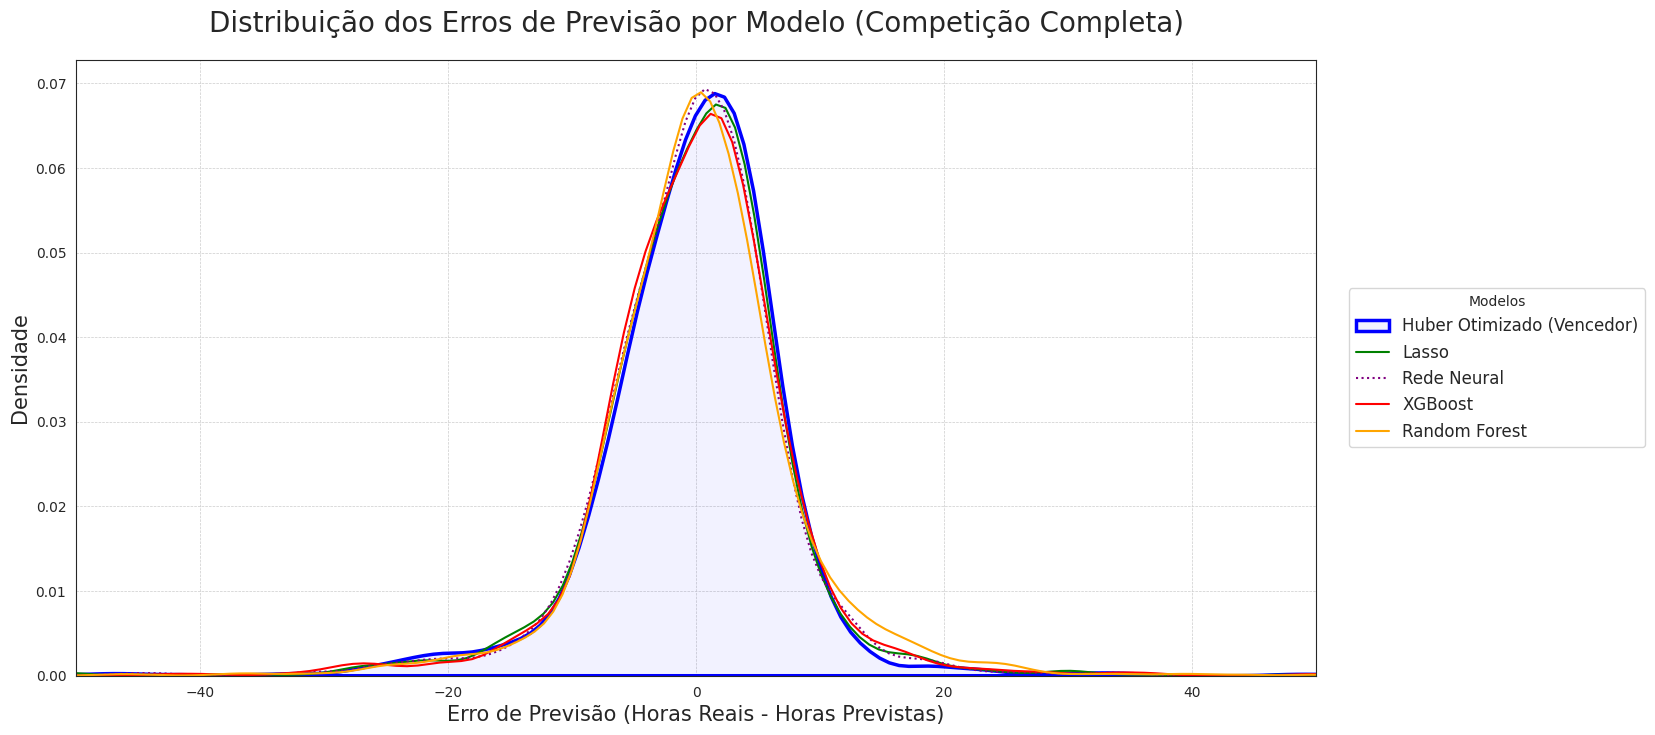

In [121]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.set_style("white")

sns.kdeplot(data=df_erros_todos, x='Huber Otimizado', label='Huber Otimizado (Vencedor)', color='blue', fill=True, alpha=0.05, linewidth=2.5)
sns.kdeplot(data=df_erros_todos, x='Lasso', label='Lasso', color='green', fill=False, linewidth=1.5)
sns.kdeplot(data=df_erros_todos, x='Rede Neural', label='Rede Neural', color='purple', fill=False, linewidth=1.5, linestyle=':')
sns.kdeplot(data=df_erros_todos, x='XGBoost', label='XGBoost', color='red', fill=False, linewidth=1.5)
sns.kdeplot(data=df_erros_todos, x='Random Forest', label='Random Forest', color='orange', fill=False, linewidth=1.5)

ax.set_title('Distribuição dos Erros de Previsão por Modelo (Competição Completa)', fontsize=20, pad=20)
ax.set_xlabel('Erro de Previsão (Horas Reais - Horas Previstas)', fontsize=15)
ax.set_ylabel('Densidade', fontsize=15)
ax.set_xlim(-50, 50)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax.legend(title='Modelos', fontsize='large', bbox_to_anchor=(1.02, 0.5), loc='center left')

plt.show()

**1. Huber Regressor (Azul)**

Ele tem o pico mais alto, ou está empatado como o mais alto. Isso confirma o que as métricas nos disseram: ele tem a maior frequência de erros muito próximos de zero.
A curva desce abruptamente a partir do pico. Isso significa que ele tem muito poucos erros de tamanho médio (por exemplo, na faixa de +/- 10 a 20 horas). Sua consistência é sua maior força.
As caudas são muito finas. Graças à sua robustez inerente a outliers, é o modelo com menor probabilidade de cometer erros catastróficos.
É o melhor "faz-tudo". Pode não ser o melhor em uma única coisa, mas é muito bom em tudo, e é por isso que venceu nas métricas agregadas (MAE e especialmente RMSE). É o modelo mais confiável e robusto.

**Random Forest (Laranja)**

Seu pico é extremamente competitivo, no mesmo nível do Huber e da Rede Neural. Ele também é excelente em acertar as previsões muito perto do valor real.
Seus "ombros" (a área de +/- 5 a +/- 20 horas) parecem ligeiramente mais espessos que os do Huber. Isso significa que ele pode estar cometendo um pouco mais de erros de tamanho médio.
As caudas parecem um pouco mais espessas que as do Huber, sugerindo uma chance um pouco maior de cometer um erro grande. É provavelmente por isso que seu RMSE foi o mais alto do grupo — alguns erros grandes, quando elevados ao quadrado, penalizam fortemente a pontuação.
O Random Forest é um modelo incrivelmente forte, visualmente quase empatado com o vencedor. Isso prova que os ensembles baseados em árvores são muito poderosos para este problema. Sua pontuação de RMSE um pouco mais fraca provavelmente se deve a um punhado de previsões muito erradas, em vez de uma falta geral de precisão.

**Rede Neural (Roxo)**

É um especialista em "acertar em cheio" quando o padrão é claro.
Visualmente, sua curva está quase perfeitamente sobreposta às curvas do Huber e do Random Forest. As diferenças sutis que levaram ao seu RMSE um pouco pior são quase impossíveis de distinguir a olho nu, mas existem nos dados. Provavelmente tem uma distribuição de erros muito semelhante à do Random Forest.
Um modelo fantástico, quase indistinguível dos melhores desempenhos visualmente. Confirma que padrões complexos e não-lineares existem, mas talvez não o suficiente para lhe dar uma vantagem decisiva sobre a abordagem robusta-linear do Huber.

**Lasso (Verde)**
Seu pico é visivelmente apenas uma fração mais baixo que os três primeiros. É bom, mas não de elite, em produzir previsões quase perfeitas.
A curva inteira é ligeiramente "mais baixa e mais gorda" que a do Huber, indicando uma dispersão geral de erros maior, o que corresponde perfeitamente às suas pontuações de MAE e RMSE um pouco mais altas.
É um modelo de linha de base sólido e confiável. Ele captura as principais tendências lineares de forma eficaz, mas carece da precisão extra dos principais concorrentes.

**XGBoost (Vermelho)**

O pico da curva vermelha é notavelmente o mais baixo do grupo. Este é o indicador visual mais claro de sua lacuna de desempenho. Teve a menor frequência de erros muito pequenos.
Seus ombros são os mais largos, mostrando mais erros de médio a grande porte.
Esses dados visuais confirmam que, para este problema específico e com este nível de ajuste de hiperparâmetros, o XGBoost foi o modelo menos preciso. Esta é uma descoberta valiosa — mostra que o algoritmo mais famoso ou complexo nem sempre é o melhor.

**O Huber vence por pontos devido às suas métricas agregadas superiores (especialmente RMSE), tornando-o a escolha mais robusta e confiável.**

# **Salvando modelo**

In [122]:
import joblib
import os

In [123]:
model_filename = 'modelo_huber_final.joblib'
scaler_filename = 'scaler.joblib'

In [124]:
joblib.dump(best_huber_final, model_filename)
print(f"Modelo Huber salvo com sucesso em: '{os.path.abspath(model_filename)}'")

Modelo Huber salvo com sucesso em: '/content/modelo_huber_final.joblib'


In [125]:
joblib.dump(scaler, scaler_filename)
print(f"Objeto Scaler salvo com sucesso em: '{os.path.abspath(scaler_filename)}'")

Objeto Scaler salvo com sucesso em: '/content/scaler.joblib'


# **Previsão do modelo**

In [132]:
model_filename = 'modelo_huber_final.joblib'
new_data_filename = 'Horas_Sem_INFOS.xlsx'
output_filename = 'previsoes_resultado.xlsx'

In [133]:
try:
    modelo_carregado = joblib.load(model_filename)
    print(f"Modelo '{model_filename}' carregado com sucesso.")
except FileNotFoundError:
    print(f"ERRO: O arquivo do modelo '{model_filename}' não foi encontrado.")
    print("Certifique-se de que ele está na mesma pasta que este script.")
    exit() # Interrompe a execução se o modelo não for encontrado

Modelo 'modelo_huber_final.joblib' carregado com sucesso.


In [134]:
try:
    df_novos_dados = pd.read_excel(new_data_filename)
    print(f"Arquivo de novos dados '{new_data_filename}' carregado. Contém {len(df_novos_dados)} linhas.")
except FileNotFoundError:
    print(f"ERRO: O arquivo de dados '{new_data_filename}' não foi encontrado.")
    exit()

Arquivo de novos dados 'Horas_Sem_INFOS.xlsx' carregado. Contém 10743 linhas.


In [136]:
if 'HET' not in df_novos_dados.columns:
    df_novos_dados['HET'] = None

In [137]:
colunas_preditoras = [col for col in df_novos_dados.columns if col not in ['ID', 'HET']]
X_novos = df_novos_dados[colunas_preditoras].copy()

In [138]:
X_novos.fillna(0, inplace=True)
print("Pré-processamento dos novos dados concluído.")

Pré-processamento dos novos dados concluído.


In [139]:
print("Realizando as previsões...")
previsoes = modelo_carregado.predict(X_novos)
print("Previsões concluídas.")

Realizando as previsões...
Previsões concluídas.


In [140]:
df_novos_dados['HET'] = previsoes

In [141]:
df_novos_dados.to_excel(output_filename, index=False)

In [142]:
print(df_novos_dados[['ID', 'HET']].head())

      ID        HET
0  10000  19.975767
1  10001  10.361186
2  10002  32.652237
3  10003   7.989860
4  10004  46.363917
